In [1]:
from SimPEG import Mesh, Maps
import numpy as np
from matplotlib.colors import LogNorm
from simpegem1d import (
    GlobalEM1DProblem, GlobalEM1DSurveyFD, get_vertical_discretization
)
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Seting up a 2D mesh and model

In [2]:
frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization(frequency, sigma_background=0.01)

257.506650707507


In [3]:
from scipy.spatial import Delaunay
def PolygonInd(mesh, pts):
    hull = Delaunay(pts)
    inds = hull.find_simplex(mesh.gridCC)>=0
    return inds

In [4]:
n_sounding = 20
dx = 20.
hx = np.ones(n_sounding) * dx
mesh = Mesh.TensorMesh([hx, hz], x0='00')
inds =  mesh.gridCC[:,1]<25
sigma = np.ones(mesh.nC) * 1./100.
sigma[inds] = 1./50.
x0 = np.r_[0., 75.]
x1 = np.r_[dx*n_sounding, 75.]
x2 = np.r_[dx*n_sounding, 90.]
x3 = np.r_[0., 200.]
pts = np.vstack((x0, x1, x2, x3, x0))
poly_inds = PolygonInd(mesh, pts)
sigma[poly_inds] = 0.1
sigma_em1d = sigma.reshape(mesh.vnC, order='F').flatten()

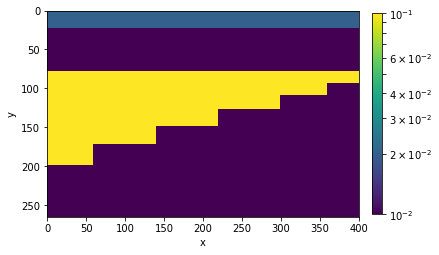

In [5]:
cb = plt.colorbar(
    mesh.plotImage(sigma, grid=False, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.03, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

In [6]:
x = mesh.vectorCCx
y = np.zeros_like(x)
z = np.ones_like(x) * 30.
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, z-30.].astype(float)

In [7]:
mapping = Maps.ExpMap(mesh)

In [8]:
survey = GlobalEM1DSurveyFD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    frequency = frequency,
    offset = np.ones_like(frequency) * 7.86,
    src_type = "VMD",
    rx_type = "Hz",
    field_type = 'secondary',
    topo = topo    
)
prob = GlobalEM1DProblem(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=2,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Use multiprocessing for parallelization
>> n_cpu: 2


In [9]:
m = np.log(sigma_em1d)

In [10]:
%%time
dobs = survey.dpred(m)

CPU times: user 60.3 ms, sys: 39.2 ms, total: 99.5 ms
Wall time: 334 ms


In [11]:
DOBS = dobs.reshape(( prob.n_sounding, 2, survey.n_frequency))

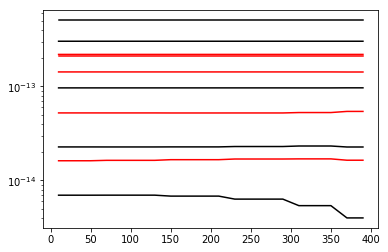

In [12]:
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, -DOBS[:,0,i_freq], 'k')
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, -DOBS[:,1,i_freq], 'r')    

In [13]:
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)

In [14]:
mesh_reg = Mesh.TensorMesh([mesh.hy, mesh.hx])

In [15]:
%%time
std = 0.05
floor = 0.
np.random.seed(1)
uncert = std*abs(dobs)+floor
survey.dobs = dobs.copy()
m0 = np.ones(mesh.nC) * np.log(1./100.)
dmisfit = DataMisfit.l2_DataMisfit(survey)
regmap = Maps.IdentityMap(mesh)
# mapping is required ... for IRLS
reg = Regularization.Sparse(
    mesh_reg, mapping=regmap,
    alpha_s=1.,
    alpha_x = 2.,
    alpha_y = 2.,    
)
p = 0
qx, qz = 1., 1.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(maxIRLSiter=10, minGNiter=1)
opt = Optimization.InexactGaussNewton(maxIter = 20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:843: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.54e+00  5.26e+03  0.00e+00  5.26e+03    8.27e+02      0              
   1  2.77e+00  8.58e+02  1.01e+02  1.14e+03    1.99e+02      0              
   2  1.38e+00  5.27e+02  1.34e+02  7.12e+02    4.16e+01      0              
   3  6.92e-01  2.55e+02  2.32e+02  4.15e+02    3.45e+01      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
L[p qx qy qz]-norm : [[0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 ...
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]]
eps_p: 1.7733009778261037 eps_q: 0.41201275697535733
eps_p: 1.7733009778261037 eps_q: 0.41201275697535733
delta phim: 2.674e-01
Target chifact overshooted, adjusting beta ...
   4  7.89e-01  8.77e+01  3.53e+02  3.66e+02    

In [16]:
sigma_est = Utils.mkvc((np.exp(mopt)).reshape((prob.n_sounding, prob.n_layer)))
sigma_est_l2 = Utils.mkvc((np.exp(invProb.l2model)).reshape((prob.n_sounding, prob.n_layer)))

In [21]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

Text(0.5,1,'Laterally-contrained model: L0 L2')

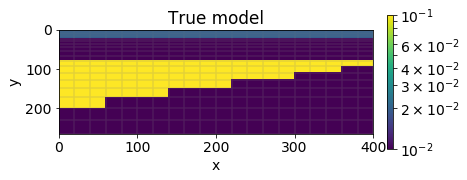

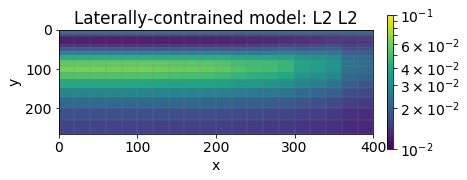

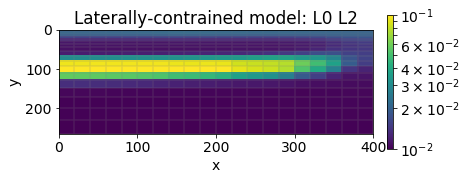

In [23]:
cb = plt.colorbar(
    mesh.plotImage(
        sigma, grid=True, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(0.5)

plt.title("True model")

cb = plt.colorbar(
    mesh.plotImage(
        sigma_est_l2, grid=True, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.title("Laterally-contrained model: L2 L2")
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(0.5)


cb = plt.colorbar(
    mesh.plotImage(
        sigma_est, grid=True, clim=(1e-2, 1e-1), pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(0.5)
plt.title("Laterally-contrained model: L0 L2")

In [18]:
PRED = invProb.dpred.reshape((prob.n_sounding, 2, survey.n_frequency))

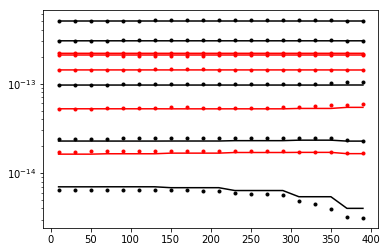

In [19]:
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, -DOBS[:,0,i_freq], 'k')
    plt.semilogy(mesh.vectorCCx, -PRED[:,0,i_freq], 'k.')
for i_freq in range(survey.n_frequency):
    plt.semilogy(mesh.vectorCCx, -DOBS[:,1,i_freq], 'r')    
    plt.semilogy(mesh.vectorCCx, -PRED[:,1,i_freq], 'r.')    